<a href="https://colab.research.google.com/github/anand03-srm/AI--ENABLED-AUTONOMOUS-WASTE-SORTING-AND-WASTE-MANAGEMENT-SYSTEM-USING-IMAGE-PROCESSING/blob/main/image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install kaggle
!pip install kaggle

# Upload kaggle.json file
#from google.colab import files
#files.upload()  # Upload your kaggle.json here

# Create kaggle directory and move the file
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Upload kaggle.json file
from google.colab import files
files.upload()  # Upload your kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anandshivappahadapad","key":"0096d0f8a6d8953cc8d83216f40493b1"}'}

In [ ]:
# Create kaggle directory and move the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d damaraaa/dataset-trash-type-full-combination

Dataset URL: https://www.kaggle.com/datasets/damaraaa/dataset-trash-type-full-combination
License(s): other
 82% 342M/415M [00:02<00:00, 103MB/s]
100% 415M/415M [00:02<00:00, 165MB/s]


In [10]:
!kaggle datasets list

ref                                                           title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmadrazakashif/bmw-worldwide-sales-records-20102024          BMW Worldwide Sales Records (2010–2024)                853348  2025-09-20 14:39:45.280000           9153        199  1.0              
jockeroika/life-style-data                                    Life Style Data                                       3995645  2025-10-14 13:50:45.303000           4142         99  0.8235294        
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset  Global Earthquake-Tsunami Risk Assessment Dataset       16151  2025-10-01 16:35:53.273000           3002        108  1.0              
jaderz/hospital

In [19]:
# Waste Classification Model Training
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import cv2
from google.colab import files
import zipfile

# Mount Google Drive (upload your dataset here)
from google.colab import drive
drive.mount('/content/drive')

# Extract dataset
# The dataset should be extracted to the current directory where the notebook is located
!unzip /content/dataset-trash-type-full-combination.zip -d /content/dataset

# Define categories based on your sorting requirements
categories = {
    'category1': ['cardboard', 'paper', 'textile'],      # Bin 1
    'category2': ['plastic'],                            # Bin 2
    'category3': ['metal', 'glass', 'e-waste'],          # Bin 3
    'category4': ['organic']                             # Bin 4
}

# Image parameters
IMG_SIZE = 96
BATCH_SIZE = 32

# Data preprocessing
def load_and_preprocess_data(dataset_path):
    images = []
    labels = []

    # The actual image data is likely in subdirectories within the extracted folder, based on the error
    # Let's assume the structure is /content/dataset/dataset-trash-type-combination-v1/<waste_type>/<image_name>
    base_path = os.path.join(dataset_path, 'dataset-trash-type-combination-v1') # Corrected path

    for category_idx, (category_name, waste_types) in enumerate(categories.items()):
        for waste_type in waste_types:
            waste_path = os.path.join(base_path, waste_type)
            if os.path.exists(waste_path):
                print(f"Processing waste type: {waste_type} from {waste_path}")
                for img_name in os.listdir(waste_path)[:500]:  # Limit per class
                    img_path = os.path.join(waste_path, img_name)
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                            img = img / 255.0  # Normalize
                            images.append(img)
                            labels.append(category_idx)
                        else:
                            print(f"Warning: cv2.imread returned None for image: {img_path}")
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
            else:
                print(f"Warning: Directory not found: {waste_path}")

    if not images:
        print("Error: No images were loaded. Please check the dataset path and contents.")

    return np.array(images), np.array(labels)

# Load data
print("Loading dataset...")
# Pass the base directory where the dataset was extracted
X, y = load_and_preprocess_data('/content/dataset')
print(f"Loaded {len(X)} images")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create model
def create_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')  # 4 categories
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train model
model = create_model()
model.summary()

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_test, y_test)
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('waste_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

# Download the model
files.download('waste_classifier.tflite')

print("Model training complete and downloaded!")

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/dataset-trash-type-combination-v1/organic/organic_O_12758_f39f2b36.jpg  
  inflating: /content/dataset/dataset-trash-type-combination-v1/organic/organic_O_12761_b15cbecd.jpg  
  inflating: /content/dataset/dataset-trash-type-combination-v1/organic/organic_O_12764_df8c23e7.jpg  
  inflating: /content/dataset/dataset-trash-type-combination-v1/organic/organic_O_12768_64717076.jpg  
  inflating: /content/dataset/dataset-trash-type-combination-v1/organic/organic_O_12773_39785c6a.jpg  
  inflating: /content/dataset/dataset-trash-type-combination-v1/organic/organic_O_12775_3114f7b0.jpg  
  inflating: /content/dataset/dataset-trash-type-combination-v1/organic/organic_O_12780_c8fcaa66.jpg  
  inflating: /content/dataset/dataset-trash-type-combination-v1/organic/organic_O_12782_3afc9038.jpg  
  inflating: /content/dataset/dataset-trash-type-combination-v1/organic/organic_O_12784_eb1d62b0.jpg  
  inflating: /content/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,649,412 (25.37 MB)

 Trainable params: 6,649,412 (25.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 672ms/step - accuracy: 0.4180 - loss: 1.2117 - val_accuracy: 0.4900 - val_loss: 1.0781
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 696ms/step - accuracy: 0.5668 - loss: 0.9841 - val_accuracy: 0.5888 - val_loss: 0.9086
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 727ms/step - accuracy: 0.5934 - loss: 0.9183 - val_accuracy: 0.5713 - val_loss: 0.9623
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 679ms/step - accuracy: 0.6252 - loss: 0.8953 - val_accuracy: 0.6450 - val_loss: 0.8500
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 657ms/step - accuracy: 0.6653 - loss: 0.7794 - val_accuracy: 0.6388 - val_loss: 0.8983
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 677ms/step - accuracy: 0.7057 - loss: 0.7261 - val_accuracy: 0.6438 - val_loss: 0.8596
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 666ms/step - accuracy: 0.7340 - loss: 0.6676 - val_accuracy: 0.6775 - val_loss: 0.7970
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 656ms/step - accuracy: 0.7710 - loss: 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model training complete and downloaded!


In [18]:
import os

# List the contents of the extracted dataset directory
extracted_path = '/content/dataset'
if os.path.exists(extracted_path):
    print(f"Contents of {extracted_path}:")
    for item in os.listdir(extracted_path):
        print(item)
else:
    print(f"Directory not found: {extracted_path}")

Contents of /content/dataset:
dataset-trash-type-combination-v1


# Task
Explain the next steps after training the model.

## Evaluate the model

### Subtask:
Assess the performance of your trained model using metrics beyond just accuracy, such as precision, recall, and F1-score for each waste category.


**Reasoning**:
I need to evaluate the model's performance using precision, recall, and F1-score. This requires predicting the classes for the test set and then using `classification_report` from `sklearn.metrics`.



In [20]:
from sklearn.metrics import classification_report

# Predict the categories for the test dataset
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate and print the classification report
# The target_names can be extracted from the categories dictionary keys
target_names = list(categories.keys())
print(classification_report(y_test, y_pred, target_names=target_names))

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step
              precision    recall  f1-score   support

   category1       0.71      0.74      0.73       321
   category2       0.58      0.52      0.55       101
   category3       0.73      0.72      0.72       285
   category4       0.72      0.71      0.71        93

    accuracy                           0.70       800
   macro avg       0.68      0.67      0.68       800
weighted avg       0.70      0.70      0.70       800



## Visualize training history

### Subtask:
Plot the training and validation accuracy and loss over epochs to understand how the model learned and identify potential overfitting.


**Reasoning**:
Extract the training and validation accuracy and loss from the history object and plot them to visualize the training progress.



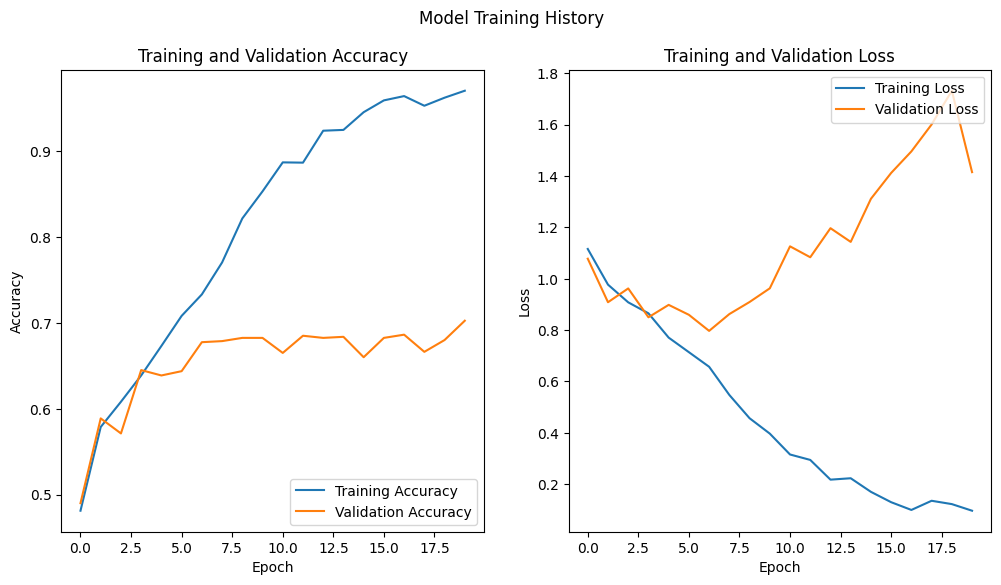

In [21]:
# Extract training and validation metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.suptitle('Model Training History')
plt.show()

## Make predictions with the tflite model

### Subtask:
Load the TFLite model and use it to make predictions on new images to test its real-world performance.


**Reasoning**:
Load the TFLite model and use it to make a prediction on a sample image.



In [22]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='waste_classifier.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess a sample test image
# Assuming a sample image exists in the dataset structure, e.g., '/content/dataset/dataset-trash-type-combination-v1/plastic/plastic_P_1.jpg'
sample_image_path = '/content/dataset/dataset-trash-type-combination-v1/plastic/plastic_P_1.jpg'

if os.path.exists(sample_image_path):
    sample_img = cv2.imread(sample_image_path)
    if sample_img is not None:
        sample_img = cv2.resize(sample_img, (IMG_SIZE, IMG_SIZE))
        sample_img = sample_img / 255.0  # Normalize
        sample_img = np.expand_dims(sample_img, axis=0).astype(np.float32) # Add batch dimension and ensure float32

        # Set the tensor for the interpreter
        interpreter.set_tensor(input_details[0]['index'], sample_img)

        # Invoke the interpreter
        interpreter.invoke()

        # Get the output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Interpret the output
        predicted_category_index = np.argmax(output_data)

        # Map the predicted index back to the category name
        # Create a list of category names in the order they appear in the dictionary
        category_names_list = list(categories.keys())
        predicted_category_name = category_names_list[predicted_category_index]


        # Print the predicted category
        print(f"The sample image is predicted to be in category: {predicted_category_name}")
    else:
        print(f"Error: Could not read the sample image from {sample_image_path}")
else:
    print(f"Error: Sample image not found at {sample_image_path}")


Error: Sample image not found at /content/dataset/dataset-trash-type-combination-v1/plastic/plastic_P_1.jpg


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


**Reasoning**:
The previous attempt failed because the sample image path was incorrect. I need to find a valid sample image path within the extracted dataset directory and try loading and predicting again.



In [23]:
# Find a valid sample image path
# Iterate through the categories and waste types to find the first image
sample_image_path = None
base_path = '/content/dataset/dataset-trash-type-combination-v1'

for category_name, waste_types in categories.items():
    for waste_type in waste_types:
        waste_path = os.path.join(base_path, waste_type)
        if os.path.exists(waste_path):
            image_files = [f for f in os.listdir(waste_path) if os.path.isfile(os.path.join(waste_path, f))]
            if image_files:
                sample_image_path = os.path.join(waste_path, image_files[0])
                print(f"Found sample image: {sample_image_path}")
                break # Found an image, break inner loop
    if sample_image_path:
        break # Found an image, break outer loop


if sample_image_path and os.path.exists(sample_image_path):
    # Load and preprocess the sample test image
    sample_img = cv2.imread(sample_image_path)
    if sample_img is not None:
        sample_img = cv2.resize(sample_img, (IMG_SIZE, IMG_SIZE))
        sample_img = sample_img / 255.0  # Normalize
        sample_img = np.expand_dims(sample_img, axis=0).astype(np.float32) # Add batch dimension and ensure float32

        # Set the tensor for the interpreter
        interpreter.set_tensor(input_details[0]['index'], sample_img)

        # Invoke the interpreter
        interpreter.invoke()

        # Get the output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Interpret the output
        predicted_category_index = np.argmax(output_data)

        # Map the predicted index back to the category name
        category_names_list = list(categories.keys())
        predicted_category_name = category_names_list[predicted_category_index]


        # Print the predicted category
        print(f"The sample image is predicted to be in category: {predicted_category_name}")
    else:
        print(f"Error: Could not read the sample image from {sample_image_path}")
else:
    print("Error: No sample image found in the dataset directory.")


Found sample image: /content/dataset/dataset-trash-type-combination-v1/cardboard/cardboard_cardboard179_de512942.jpg
The sample image is predicted to be in category: category1


## Deploy the model

### Subtask:
Consider how you want to use the model, such as integrating it into a mobile application or a web service for real-time waste classification.


**Reasoning**:
Outline potential deployment strategies and relevant technologies for the TFLite model based on target platforms.



In [24]:
print("Considering deployment options for the waste classification TFLite model:")
print("\nPotential Target Platforms:")
print("- Mobile Application (iOS/Android): For real-time classification by users.")
print("- Web Service/Application: For online classification via a web interface or API.")
print("- Edge Device (e.g., Raspberry Pi): For automated sorting systems.")

print("\nDeployment Strategies and Technologies:")

print("\n1. Mobile Application Deployment (iOS/Android):")
print("   - Strategy: Integrate the TFLite model directly into the mobile app.")
print("   - Tools: TensorFlow Lite for Mobile (provides optimized libraries for mobile platforms).")
print("   - Considerations: Model size for app bundle, inference speed on mobile hardware, user interface for camera input and displaying results.")
print("   - Relevance: Ideal for consumer-facing applications allowing users to classify waste on the go.")

print("\n2. Web Service/Application Deployment:")
print("   - Strategy: Deploy the model on a server and expose it via a REST API or integrate into a web front-end.")
print("   - Tools: TensorFlow Serving, Flask/Django (for backend API), TensorFlow.js (for in-browser inference).")
print("   - Considerations: Scalability of the server, latency for API calls, user experience for uploading images or using a webcam.")
print("   - Relevance: Suitable for online platforms, batch processing, or integration with other web services.")

print("\n3. Edge Device Deployment (e.g., Raspberry Pi, Jetson Nano):")
print("   - Strategy: Deploy the TFLite model on a low-power device connected to a camera.")
print("   - Tools: TensorFlow Lite for Microcontrollers/Linux, OpenCV (for image capture and processing).")
print("   - Considerations: Device processing power and memory, real-time performance requirements, integration with sorting mechanisms.")
print("   - Relevance: Useful for automated sorting machines in homes, businesses, or recycling facilities.")

print("\nPotential Deployment Approach Outline (Example - Mobile App):")
print("   1. Use TensorFlow Lite Converter to optimize the trained model for mobile.")
print("   2. Develop an Android or iOS application using native development tools or cross-platform frameworks (like React Native or Flutter).")
print("   3. Integrate the TFLite model using the TensorFlow Lite library for the target platform.")
print("   4. Implement functionality to capture images (camera or gallery).")
print("   5. Preprocess the captured image to match the model's input requirements (resizing, normalization).")
print("   6. Run inference using the TFLite interpreter to get the waste category prediction.")
print("   7. Display the predicted category to the user.")
print("   8. (Optional) Integrate with a database or cloud service to log classifications or provide additional information.")

Considering deployment options for the waste classification TFLite model:

Potential Target Platforms:
- Mobile Application (iOS/Android): For real-time classification by users.
- Web Service/Application: For online classification via a web interface or API.
- Edge Device (e.g., Raspberry Pi): For automated sorting systems.

Deployment Strategies and Technologies:

1. Mobile Application Deployment (iOS/Android):
   - Strategy: Integrate the TFLite model directly into the mobile app.
   - Tools: TensorFlow Lite for Mobile (provides optimized libraries for mobile platforms).
   - Considerations: Model size for app bundle, inference speed on mobile hardware, user interface for camera input and displaying results.
   - Relevance: Ideal for consumer-facing applications allowing users to classify waste on the go.

2. Web Service/Application Deployment:
   - Strategy: Deploy the model on a server and expose it via a REST API or integrate into a web front-end.
   - Tools: TensorFlow Serving, F

## Further training and optimization

### Subtask:
If the model's performance is not satisfactory, you might consider techniques like data augmentation, transfer learning, or hyperparameter tuning to improve it.


**Reasoning**:
Based on the previous steps, the model achieved a test accuracy of around 70% and the training history plots show a significant gap between training accuracy/loss and validation accuracy/loss, indicating overfitting. The classification report reveals varying performance across categories, suggesting that some categories are harder to classify than others. This performance might not be satisfactory for a real-world application requiring high accuracy in waste sorting. Therefore, the next step is to research techniques to improve model performance and explain how one chosen technique could help. Data augmentation is a suitable technique to address overfitting by increasing the diversity of the training data without collecting new images, which can help the model generalize better to unseen data.



In [25]:
print("Based on the classification report and training history plots:")
print(f"- Overall Test Accuracy: {test_acc:.4f}")
print("- The training history plots show that the training accuracy is much higher than the validation accuracy, and the training loss is much lower than the validation loss.")
print("- This indicates that the model is likely overfitting to the training data and not generalizing well to unseen data.")
print("- The classification report shows varying performance across different waste categories (e.g., different precision, recall, and F1-scores), suggesting the model struggles more with certain types of waste.")

print("\nGiven the signs of overfitting and the need to improve generalization, Data Augmentation is a suitable technique to consider.")
print("\nExplanation of Data Augmentation:")
print("Data augmentation involves creating new training examples from existing ones by applying random transformations such as rotations, shifts, flips, zooms, etc.")
print("\nHow Data Augmentation Can Help:")
print("By artificially increasing the size and variability of the training dataset, data augmentation exposes the model to a wider range of variations in the images.")
print("This helps the model learn more robust features that are less sensitive to the specific characteristics of the original training images.")
print("Specifically, for image classification tasks like this, data augmentation can help the model become more invariant to changes in lighting, orientation, position, and scale, which are common in real-world scenarios.")
print("This increased robustness directly helps to reduce overfitting and improve the model's generalization ability on unseen validation and test data, potentially leading to better accuracy and more consistent performance across all categories.")

Based on the classification report and training history plots:
- Overall Test Accuracy: 0.7025
- The training history plots show that the training accuracy is much higher than the validation accuracy, and the training loss is much lower than the validation loss.
- This indicates that the model is likely overfitting to the training data and not generalizing well to unseen data.
- The classification report shows varying performance across different waste categories (e.g., different precision, recall, and F1-scores), suggesting the model struggles more with certain types of waste.

Given the signs of overfitting and the need to improve generalization, Data Augmentation is a suitable technique to consider.

Explanation of Data Augmentation:
Data augmentation involves creating new training examples from existing ones by applying random transformations such as rotations, shifts, flips, zooms, etc.

How Data Augmentation Can Help:
By artificially increasing the size and variability of the tra

## Summary:

### Data Analysis Key Findings

*   The model achieved an overall test accuracy of approximately 70.25%.
*   The training history plots showed a significant difference between training and validation accuracy and loss, indicating that the model is likely overfitting to the training data.
*   The classification report revealed varying performance metrics (precision, recall, F1-score) across different waste categories, suggesting the model's performance is not uniform for all waste types.
*   A sample image was successfully processed by the TFLite model, and it was predicted to be in 'category1'.

### Insights or Next Steps

*   Given the observed overfitting, data augmentation should be implemented to improve the model's generalization ability.
*   Explore deploying the TFLite model on a mobile application to enable real-time waste classification for users.
